### import Required libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from typing import Type, List
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision.datasets import SVHN, MNIST
import matplotlib.pyplot as plt
from torchvision.transforms import Compose, Resize, Grayscale, ToTensor, Normalize

### Define label smoothing integrated with Cross entropy

In [2]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, classes, smoothing=0.25, dim=-1):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim

    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

### Define BasicBlock

In [3]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x if self.downsample is None else self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)
        return out

### ResNet model 

In [4]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10, img_channels=3):
        super().__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(img_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )
        layers = [block(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def resnet18(num_classes=10, img_channels=3):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes, img_channels)


### Base Transformation

In [6]:
transform_svhn = Compose([
    ToTensor(),
    Normalize(mean=[0.4377, 0.4438, 0.4728], std=[0.1201, 0.1231, 0.1052]) 
])


transform_mnist = Compose([
    Resize((32, 32)), 
    Grayscale(num_output_channels=3),
    ToTensor(),
    Normalize(mean=[0.1307, 0.1307, 0.1307], std=[0.3015, 0.3015, 0.3015])
])

### load and loaders

In [7]:
train_dataset_svhn = SVHN(root='./data', split='train', download=True, transform=transform_svhn)
test_dataset_svhn = SVHN(root='./data', split='test', download=True, transform=transform_svhn)

train_loader_svhn = DataLoader(dataset=train_dataset_svhn, batch_size=16, shuffle=True, num_workers=2)
test_loader_svhn = DataLoader(dataset=test_dataset_svhn, batch_size=16, shuffle=False, num_workers=2)

train_dataset_mnist = MNIST(root='./data', train=True, download=True, transform=transform_mnist)
test_dataset_mnist = MNIST(root='./data', train=False, download=True, transform=transform_mnist)

train_loader_mnist = DataLoader(dataset=train_dataset_mnist, batch_size=16, shuffle=True, num_workers=2)
test_loader_mnist = DataLoader(dataset=test_dataset_mnist, batch_size=16, shuffle=False, num_workers=2)

print("Data loaders have been created.")

100%|██████████| 182040794/182040794 [00:23<00:00, 7882921.16it/s] 


100%|██████████| 64275384/64275384 [00:10<00:00, 6087309.46it/s]


100%|██████████| 9912422/9912422 [00:00<00:00, 95368291.35it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 50201282.15it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 25656127.54it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7369643.62it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Data loaders have been created.


### criterion - model - optimizer 

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = resnet18().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
criterion = LabelSmoothingCrossEntropy(classes=10)

### Training 

In [9]:
num_epochs = 10
losses = []

for epoch in tqdm(range(num_epochs), desc='Training Epochs'):
    model.train() 
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader_svhn: 
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader_svhn)
    losses.append(epoch_loss)
    scheduler.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Training Accuracy: {100.*correct/total:.2f}%')

Training Epochs:  10%|█         | 1/10 [01:10<10:37, 70.86s/it]

Epoch 1/10, Training Loss: 1.7991, Training Accuracy: 59.90%


Training Epochs:  20%|██        | 2/10 [02:19<09:15, 69.41s/it]

Epoch 2/10, Training Loss: 1.3744, Training Accuracy: 84.64%


Training Epochs:  30%|███       | 3/10 [03:27<08:02, 68.90s/it]

Epoch 3/10, Training Loss: 1.3020, Training Accuracy: 88.86%


Training Epochs:  40%|████      | 4/10 [04:34<06:49, 68.18s/it]

Epoch 4/10, Training Loss: 1.2638, Training Accuracy: 91.14%


Training Epochs:  50%|█████     | 5/10 [05:42<05:40, 68.09s/it]

Epoch 5/10, Training Loss: 1.2415, Training Accuracy: 92.43%


Training Epochs:  60%|██████    | 6/10 [06:50<04:32, 68.08s/it]

Epoch 6/10, Training Loss: 1.2236, Training Accuracy: 93.51%


Training Epochs:  70%|███████   | 7/10 [07:58<03:23, 67.87s/it]

Epoch 7/10, Training Loss: 1.2143, Training Accuracy: 94.07%


Training Epochs:  80%|████████  | 8/10 [09:06<02:16, 68.00s/it]

Epoch 8/10, Training Loss: 1.1979, Training Accuracy: 95.09%


Training Epochs:  90%|█████████ | 9/10 [10:13<01:07, 67.75s/it]

Epoch 9/10, Training Loss: 1.1893, Training Accuracy: 95.61%


Training Epochs: 100%|██████████| 10/10 [11:20<00:00, 68.10s/it]

Epoch 10/10, Training Loss: 1.1813, Training Accuracy: 96.08%


### plotting the loss 

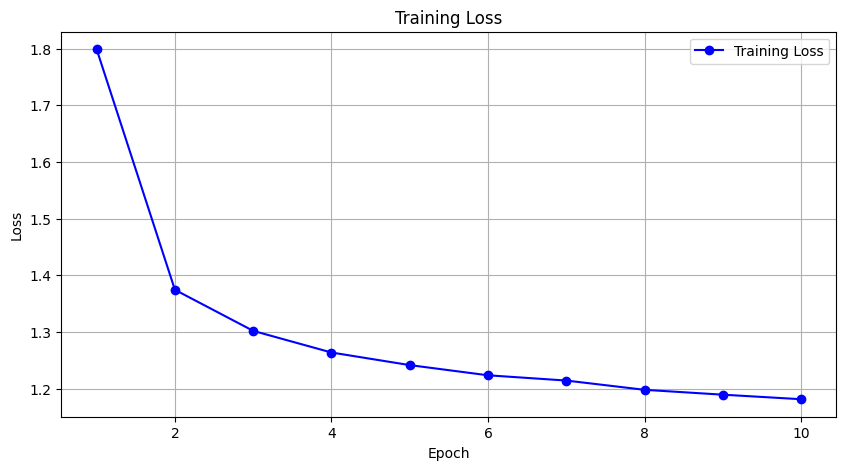

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), losses, marker='o', color='blue', label='Training Loss')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

### Test model definition 

In [14]:
def test_model(model, test_loader):
    model.eval() 
    correct = 0
    total = 0
    with torch.no_grad(): 
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')
    return accuracy

### Test Results 

In [15]:
accuracy_svhn = test_model(model, test_loader_svhn)

Accuracy: 92.59%


In [16]:
accuracy_mnist = test_model(model, test_loader_mnist)

Accuracy: 72.42%
